<b><FONT size="8" color='navy'>Challenge Veolia 2022: Prédiction de la concentration de dioxyde de soufre (SO2) </FONT>
> <b><FONT size="6" color='olive'>Groupe : Fancello Marie Clara, Germini Eva </FONT>
>> <b><FONT size="4" color='teal'> L'objectif de ce projet est de prédire la concentration de dioxyde de soufre (SO2) en μg / m³ à la station "MAS" (dans le Havre) à chaque heure au cours des 12 prochaines heures à partir d'un réseau de capteurs implentés dans d'autres stations. </FONT>

<b><FONT size="4" color='navy'>Importation des librairies </FONT>

In [2]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 87 kB/s 


In [3]:
# Utilisation de Google Colab
from google.colab import drive

import os
import warnings
import numpy as np
import pandas as pd

# Dataviz
import matplotlib.pyplot as plt
import seaborn as sns

# Traitement des donnees GPS 
from geopy import distance

# Train/Valid Split
from sklearn.model_selection import train_test_split

# Machine Learning 
from sklearn.linear_model import ElasticNet
from catboost import CatBoostRegressor

# Deep Learning 
import keras
import tensorflow as tf
from keras import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Metric
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")

<b><FONT size="5" color='olive'> 1) Premiers traitements de la base de données </FONT>


<b><FONT size="4" color='teal'>1.1) Importation des datasets </FONT>

In [5]:
# Path
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Le drive des GIRLZ/Deep Learning/projet/'

Mounted at /content/drive


In [ ]:
# Import dataset
X_train = pd.read_csv(data_dir + 'input_train_wide_format.csv', index_col = "ID")
y_train = pd.read_csv(data_dir + 'output_train_wide_format.csv', index_col = "ID") 
X_test = pd.read_csv(data_dir + 'input_test_wide_format_b10i0rq.csv', index_col = "ID") 
y_test = pd.read_csv(data_dir + 'output_test_rand.csv') # Exemple du format de sorti 

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X_train.head()

weekday-48  weekday-47  weekday-46  weekday-45  weekday-44  weekday-43  \
ID                                                                           
0            7           7           7           7           7           7   
1            7           7           7           7           7           7   
2            7           7           7           7           7           7   
3            7           7           7           7           7           7   
4            7           7           7           7           7           7   

    weekday-42  weekday-41  weekday-40  weekday-39  weekday-38  weekday-37  \
ID                                                                           
0            7           7           7           7           7           7   
1            7           7           7           7           7           7   
2            7           7           7           7           7           7   
3            7           7           7           7           7           7   
4            7           7           7           7           7           7   

    weekday-36  weekday-35  weekday-34  weekday-33  weekday-32  weekday-31  \
ID                                                                           
0            7           7           7           7           7           7   
1            7           7           7           7           7           7   
2            7           7           7           7           7           7   
3            7           7           7           7           7           7   
4            7           7           7           7           7           7   

    weekday-30  weekday-29  weekday-28  weekday-27  weekday-26  weekday-25  \
ID                                                                           
0            7           7           7           7           7           1   
1            7           7           7           7           1           1   
2            7           7           7           1           1           1   
3            7           7           1           1           1           1   
4            7           1           1           1           1           1   

    weekday-24  weekday-23  weekday-22  weekday-21  weekday-20  weekday-19  \
ID                                                                           
0            1           1           1           1           1           1   
1            1           1           1           1           1           1   
2            1           1           1           1           1           1   
3            1           1           1           1           1           1   
4            1           1           1           1           1           1   

    weekday-18  weekday-17  weekday-16  weekday-15  weekday-14  weekday-13  \
ID                                                                           
0            1           1           1           1           1           1   
1            1           1           1           1           1           1   
2            1           1           1           1           1           1   
3            1           1           1           1           1           1   
4            1           1           1           1           1           1   

    weekday-12  weekday-11  weekday-10  weekday-9  weekday-8  weekday-7  \
ID                                                                        
0            1           1           1          1          1          1   
1            1           1           1          1          1          1   
2            1           1           1          1          1          1   
3            1           1           1          1          1          1   
4            1           1           1          1          1          1   

    weekday-6  weekday-5  weekday-4  weekday-3  weekday-2  weekday-1  hour-48  \
ID                                                                              
0           1          1          

In [ ]:
y_train.head()

,SO2_MAS+0,SO2_MAS+1,SO2_MAS+2,SO2_MAS+3,SO2_MAS+4,SO2_MAS+5,SO2_MAS+6,SO2_MAS+7,SO2_MAS+8,SO2_MAS+9,SO2_MAS+10,SO2_MAS+11
ID,,,,,,,,,,,,
0,1,2,2,2,3,3,4,3,2,2,1,2
1,2,2,2,3,3,4,3,2,2,1,2,2
2,2,2,3,3,4,3,2,2,1,2,2,1
3,2,3,3,4,3,2,2,1,2,2,1,1
4,3,3,4,3,2,2,1,2,2,1,1,1


Grâce aux variables "weekday" et "hour", nous consatons que les données du test ne sont pas chronologiques. Ces données sont tirées aléatoirement: 

In [ ]:
X_test.head()

weekday-48  weekday-47  weekday-46  weekday-45  weekday-44  weekday-43  \
ID                                                                           
1            4           4           4           4           4           4   
2            6           6           6           6           6           6   
3            2           2           2           2           2           2   
4            7           7           7           7           7           7   
5            4           4           4           4           4           4   

    weekday-42  weekday-41  weekday-40  weekday-39  weekday-38  weekday-37  \
ID                                                                           
1            4           4           4           4           4           4   
2            6           7           7           7           7           7   
3            2           3           3           3           3           3   
4            7           7           7           7           7           7   
5            4           5           5           5           5           5   

    weekday-36  weekday-35  weekday-34  weekday-33  weekday-32  weekday-31  \
ID                                                                           
1            4           4           4           4           4           4   
2            7           7           7           7           7           7   
3            3           3           3           3           3           3   
4            7           7           7           7           7           7   
5            5           5           5           5           5           5   

    weekday-30  weekday-29  weekday-28  weekday-27  weekday-26  weekday-25  \
ID                                                                           
1            4           5           5           5           5           5   
2            7           7           7           7           7           7   
3            3           3           3           3           3           3   
4            7           1           1           1           1           1   
5            5           5           5           5           5           5   

    weekday-24  weekday-23  weekday-22  weekday-21  weekday-20  weekday-19  \
ID                                                                           
1            5           5           5           5           5           5   
2            7           7           7           7           7           7   
3            3           3           3           3           3           3   
4            1           1           1           1           1           1   
5            5           5           5           5           5           5   

    weekday-18  weekday-17  weekday-16  weekday-15  weekday-14  weekday-13  \
ID                                                                           
1            5           5           5           5           5           5   
2            7           1           1           1           1           1   
3            3           4           4           4           4           4   
4            1           1           1           1           1           1   
5            5           6           6           6           6           6   

    weekday-12  weekday-11  weekday-10  weekday-9  weekday-8  weekday-7  \
ID                                                                        
1            5           5           5          5          5          5   
2            1           1           1          1          1          1   
3            4           4           4          4          4          4   
4            1           1           1          1          1          1   
5            6           6           6          6          6          6   

    weekday-6  weekday-5  weekday-4  weekday-3  weekday-2  weekday-1  hour-48  \
ID                                                                              
1           5          6          

In [ ]:
# Dimensions 
print("La dimension du dataset des variables explicatives est de", X_train.shape)
print("La dimension du dataset des variables expliquées est de ", y_train.shape)
print("La dimension du dataset de test est de ", X_test.shape)

La dimension du dataset des variables explicatives est de (6089, 2064)
La dimension du dataset des variables expliquées est de  (6089, 12)
La dimension du dataset de test est de  (168, 2064)


In [ ]:
# Type des variables 
print("Il y a", X_train._get_numeric_data().shape[1], "variables explicatives numériques.")
print("Il y a", X_train.select_dtypes(include = ['object']).shape[1], "variables explicatives de type object.")
print("Il n'y a que des variables numériques dans y_train:", y_train._get_numeric_data().shape[1])

Il y a 1776 variables explicatives numériques.
Il y a 288 variables explicatives de type object.
Il n'y a que des variables numériques dans y_train: 12


<b><FONT size="4" color='teal'>1.2) Analyse et traitement des valeurs manquantes </FONT>

- Il y a des valeurs manquantes seulement au sein des numériques dans X_train. 
- y_train ne présente pas de NA. 

In [ ]:
# Pourcentage de NA dans les variables continues 
liste_data = [X_train._get_numeric_data(), y_train]
max_list = []
liste_var_NA = []
for elt in liste_data: 
  percent_NA = elt.isnull().sum() * 100 / len(elt) # Pourcentage de NA 
  df_percent_NA = pd.DataFrame({'col_NA': percent_NA})
  mask = df_percent_NA["col_NA"] > 0
  NA = df_percent_NA[mask]
  max = NA['col_NA'].max()
  nb_var_NA = NA.shape[0]
  liste_var_NA.append(nb_var_NA)
  max_list.append(max)
  max_list = [0 if pd.isna(x) else x for x in max_list]
print("Les nombres de variables numériques avec des NA dans X_train et y_train sont respectivement de:",liste_var_NA,".")
print("Les pourcentages de NA maximals par variable dans X_train et y_train sont respectivement de:",max_list,".")

Les nombres de variables numériques avec des NA dans X_train et y_train sont respectivement de: [720, 0] .
Les pourcentages de NA maximals par variable dans X_train et y_train sont respectivement de: [0.032846115946789295, 0] .


In [ ]:
# Pourcentage de NA dans les variables de type object 
liste_data = [X_train.select_dtypes(include=['object']), X_train.select_dtypes(include=['object'])]
max_list = []
liste_var_NA = []
for elt in liste_data: 
  percent_NA = elt.isnull().sum() * 100 / len(elt) # Pourcentage de NA
  df_percent_NA = pd.DataFrame({'col_NA': percent_NA})
  mask = df_percent_NA["col_NA"] > 0
  NA = df_percent_NA[mask]
  max = NA['col_NA'].max()
  nb_var_NA = NA.shape[0]
  liste_var_NA.append(nb_var_NA)
  max_list.append(max)
  max_list = [0 if pd.isna(x) else x for x in max_list]
print("Les nombres de variables de type object avec des NA dans X_train et y_train sont respectivement de:",liste_var_NA,".")
print("Les pourcentages de NA maximals par variable de type object dans y_train et X_test sont respectivement de:",max_list,".")

Les nombres de variables de type object avec des NA dans X_train et y_train sont respectivement de: [0, 0] .
Les pourcentages de NA maximals par variable de type object dans y_train et X_test sont respectivement de: [0, 0] .


Nous traitons les valeurs manquantes par la valeur suivante: 

In [ ]:
X_train = X_train.fillna(method='bfill')
X_test = X_test.fillna(method='bfill')

<b><FONT size="5" color='olive'> 2) Exploratary Data Analysis (EDA) et datavizualization </FONT>

<b><FONT size="4" color='teal'>2.1) Etude des variables d'output (SO2_MAS) </FONT>

>> <b><FONT size="3" color='black'> La moyenne supérieure à la médiane indique que les variables d'intérêt présentent des valeurs extrêmes. Cette constation est confirmée par le contraste entre la valeur du troisième quantile égale à 1 et le maximum égal à 156. </FONT>

In [ ]:
y_train.describe() # Stat desc

,SO2_MAS+0,SO2_MAS+1,SO2_MAS+2,SO2_MAS+3,SO2_MAS+4,SO2_MAS+5,SO2_MAS+6,SO2_MAS+7,SO2_MAS+8,SO2_MAS+9,SO2_MAS+10,SO2_MAS+11
count,6089.000000,6089.000000,6089.000000,6089.000000,6089.000000,6089.000000,6089.000000,6089.000000,6089.000000,6089.000000,6089.000000,6089.000000
mean,1.326326,1.326162,1.325833,1.325505,1.325177,1.324684,1.324191,1.323534,1.323042,1.322713,1.322385,1.322220
std,5.859539,5.859562,5.859580,5.859599,5.859617,5.859602,5.859587,5.859512,5.859497,5.859515,5.859533,5.859556
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000


>>> - Les valeurs extrêmes se produisent dans un intervalle de temps restreint: lorsque l'émission de soufre est élevée à l'heure h, alors elle l'est également pour les heures suivantes. C'est pour cette raison que nous traitons les valeurs manquantes par la méthode "backward". 
- Cependant, l'émission de soufre ne présente pas de saisonnalité. Elle ne dépend donc pas de l'année, des mois, ni des jours de la semaine. Nous supprimons donc les variable contenant "weekday". 
- Acune tendance n'est observée. 
- Les outliers constatés précédemment se situe en début et fin de période. Il est donc compliqué d'utiliser un échantillon de validation splitté par une date de cutoff. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d6b29e190>,
      dtype=object)

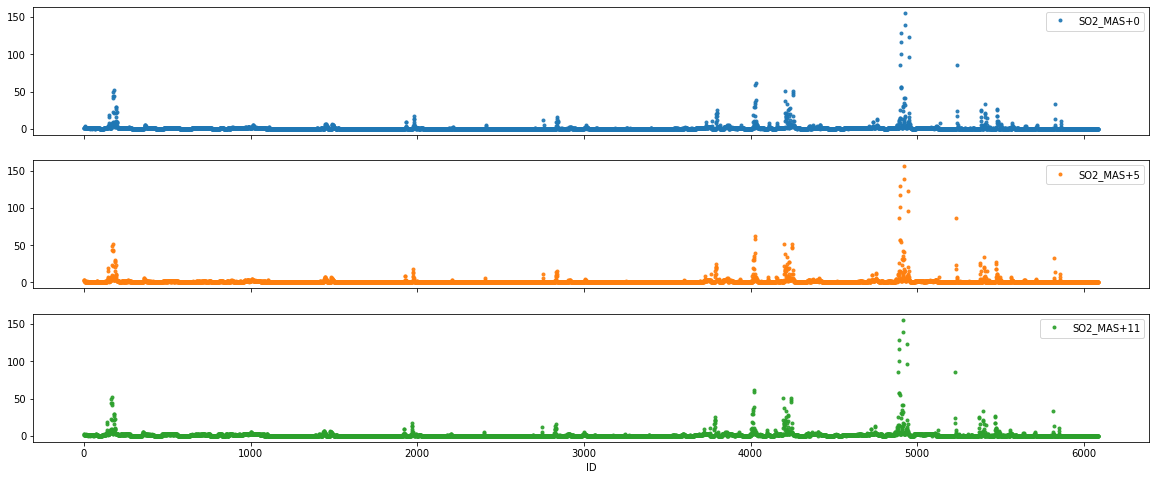

In [ ]:
y_train[["SO2_MAS+0", "SO2_MAS+5", "SO2_MAS+11"]].plot(marker = '.', alpha = 0.9, linestyle = 'None', figsize = (20, 8), subplots = True) # lineplot

In [ ]:
# Suppression de "weekday"
col_1 = [k for k in X_train.columns if 'weekday' in k]
X_train = X_train.drop(columns = col_1)
X_test = X_test.drop(columns = col_1)

>>> - Les distributions des variables d'output sont similaires. 
- Il y a une forte concentration de valeurs égales ou proches de 0. 
- La moyenne est tirée vers le haut par des valeurs extrêmes positives. 

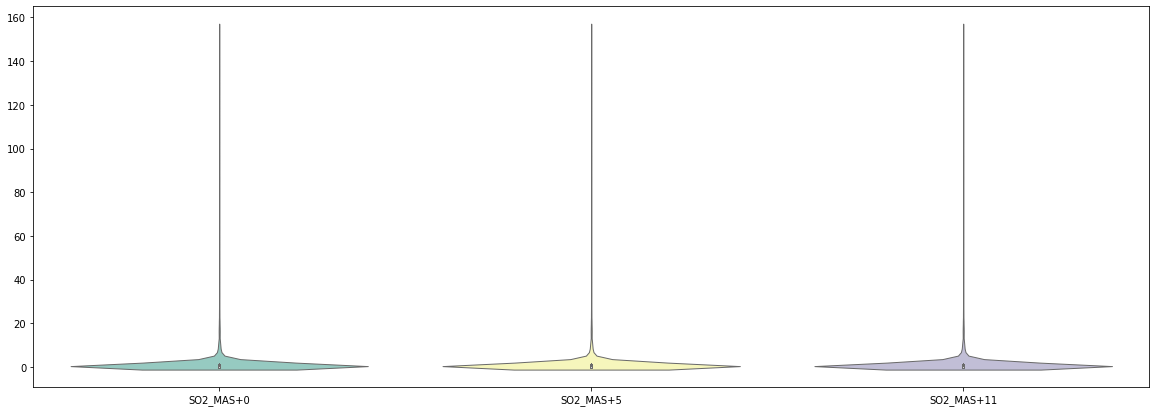

In [ ]:
var_y = y_train[["SO2_MAS+0", "SO2_MAS+5", "SO2_MAS+11"]]
f, ax = plt.subplots(figsize = (20, 7))
sns.violinplot(data = var_y, palette = "Set3", bw = .2, cut = 1, linewidth = 1)

<b><FONT size="4" color='teal'>2.2) Analyse de l'émission de SO2 à d'autres stations </FONT>

>>> - Le taux de SO2 dans l'air est souvent proche de 0 à chaque station. 
- Le taux de SO2 à la station CAU présente des valeurs extrêmes plus importantes. 
- La distribution de la variables SO2 de HVH est proche de celle de notre variable d'intérêt. Cela est peut être dû à la classe du sol similaire à MAS ou à la proximité avec cette dernière. Nous analyserons ultérieurement ces deux facteurs. 

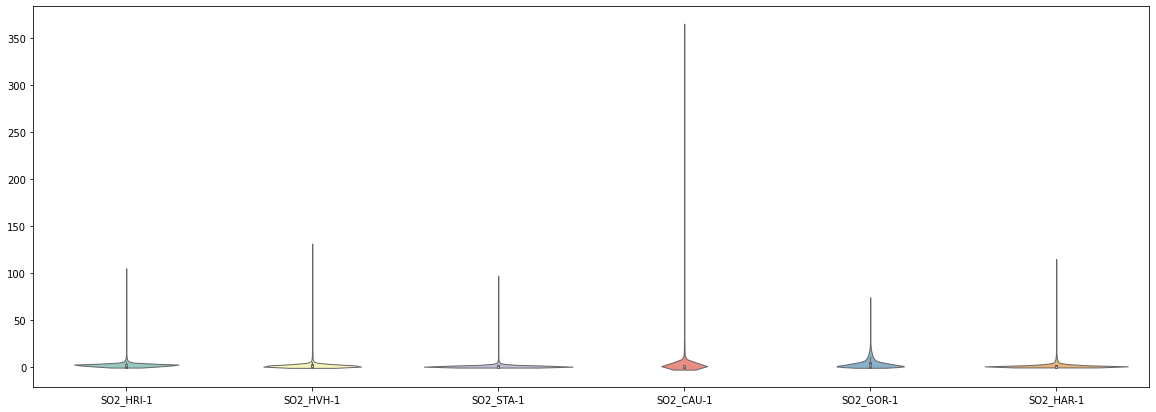

In [ ]:
var_S02 = X_train[['SO2_HRI-1', 'SO2_HVH-1', 'SO2_STA-1','SO2_CAU-1','SO2_GOR-1','SO2_HAR-1']]
f, ax = plt.subplots(figsize = (20, 7))
sns.violinplot(data = var_S02, palette = "Set3", bw = .2, cut = 1, linewidth = 1)

**Regardons si les valeurs extrêmes se produisent pour les mêmes observations:**

>>> - La variable HVH à une fois de plus le même comportement que la variable MAS. 
- La variable STA a également les mêmes outliers, cependant ses outliers sont plus faibles comme constaté sur les violin plot précédents. 

In [ ]:
liste_station = ['SO2_HRI-1', 'SO2_HVH-1', 'SO2_STA-1','SO2_CAU-1','SO2_GOR-1','SO2_HAR-1']
for elt in liste_station: 
  a = y_train.sort_values(by = 'SO2_MAS+0', ascending = False).iloc[0:100, :].index # Indices possedant des outliers dans MAS 
  b = X_train.sort_values(by= elt, ascending = False).iloc[0:100, :].index # Indices possedant des outliers pour les autres stations
  diff = set(a) - set(b)
  print("{} outliers sont communs chez SO2_MAS+1 et {}.".format(len(a) - len(diff), elt))

46 outliers sont communs chez SO2_MAS+1 et SO2_HRI-1.
53 outliers sont communs chez SO2_MAS+1 et SO2_HVH-1.
53 outliers sont communs chez SO2_MAS+1 et SO2_STA-1.
32 outliers sont communs chez SO2_MAS+1 et SO2_CAU-1.
10 outliers sont communs chez SO2_MAS+1 et SO2_GOR-1.
14 outliers sont communs chez SO2_MAS+1 et SO2_HAR-1.


**Regardons maintenant la corrélation:**

>>> - Les émissions de SO2 aux stations HVH, CAU, STA et HRI sont corrélées à l'émission de soufre à la station MAS. Cependant, ces coefficients restent faibles. 
- L'émission de SO2 à la station HAR ayant peu de valeurs extrêmes en commun avec celle de la station MAS n'est pas corrélée avec cette dernière.

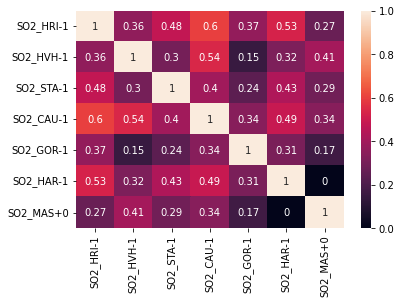

In [ ]:
SO2 = ['SO2_HRI-1', 'SO2_HVH-1', 'SO2_STA-1','SO2_CAU-1','SO2_GOR-1','SO2_HAR-1']

corr_df_SO2 = pd.concat([X_train[SO2], y_train['SO2_MAS+0']], axis = 1)
corrMatrix1 = round(corr_df_SO2.corr(method = "spearman"), 2) # Spearman car presence d'outliers, ne suit pas une loi normale 
sns.heatmap(corrMatrix1, annot = True) # Etiquettes de donnees
plt.show()

**Analyse de la classe du sol:**

>>> La classe du sol ne semble pas impacter les variables d'output: 
- Nous avons vu précédemment que le taux de SO2 à la station HAR n'est pas corrélé à celui de la station MAS. Cependant, ces derniers ont la même classe du sol. 
- Celui de la station CAU (corrélé à y) ne possède pas la même classe du sol. 

In [ ]:
var_land_cover = X_train[['land_cover_class_HRI-1','land_cover_class_HVC-1','land_cover_class_CAU-1','land_cover_class_GOR-1','land_cover_class_HAR-1','land_cover_class_MAS-1']]
var_land_cover.describe()

,land_cover_class_HRI-1,land_cover_class_HVC-1,land_cover_class_CAU-1,land_cover_class_GOR-1,land_cover_class_HAR-1,land_cover_class_MAS-1
count,6089,6089,6089,6089,6089,6089
unique,1,1,1,1,1,1
top,Port areas,Continuous urban fabric,Green urban areas,Discontinuous urban fabric,Continuous urban fabric,Continuous urban fabric
freq,6089,6089,6089,6089,6089,6089


**Analyse des coordonnées GPS:**

>>> La localisation des stations semble avoir un impact sur l'émission de SO2 à la station MAS: 
- Les stations HVH et CAU, correlées à y, sont proches de la station MAS, respectivement à environ 4 et 5 km de MAS. 
- La station GOR, très faiblement correlée à y, est distante de la station MAS. 

In [ ]:
# Liste des coordonnees GPS
col_1 = [k for k in X_train.columns if 'x_wgs84' in k]
col_2 = [k for k in col_1 if '-13' in k]
col_4 = [k for k in X_train.columns if 'y_wgs84' in k]
col_5 = [k for k in col_4 if '-13' in k]

x_gps = pd.DataFrame(X_train[col_2].iloc[0]).reset_index(drop = True)
y_gps = pd.DataFrame(X_train[col_5].iloc[0]).reset_index(drop = True)

# Table des coordonnees GPS
coord = pd.concat([x_gps, y_gps], axis = 1)
coord.columns = ['x','y']
coord = coord.set_index([pd.Index(['HRI', 'HVH', 'MAS', 'STA', 'CAU', 'GOR', 'HAR'])])
coord

# Mesure des distances
liste_index = coord.index
for row in range(0,len(coord)):
  if liste_index[row] != "MAS":
    a = round(distance.distance((coord.iloc[row,0], coord.iloc[row,1]), (coord.iloc[2, 0], coord.iloc[2,1])).km, 2)
    print("La distance entre {} et MAS est de {} km.".format(liste_index[row], a))

La distance entre HRI et MAS est de 4.74 km.
La distance entre HVH et MAS est de 4.95 km.
La distance entre STA et MAS est de 6.45 km.
La distance entre CAU et MAS est de 3.7 km.
La distance entre GOR et MAS est de 9.94 km.
La distance entre HAR et MAS est de 6.57 km.


<b><FONT size="4" color='teal'>2.3) Analyse des autres variables </FONT>

In [ ]:
# Variables categorielles non discriminates
var_unique = []
for var in X_train.select_dtypes(include = ['object']):
  if X_train.select_dtypes(include = ['object'])[var].nunique() == 1:
    var_unique.append(var)
print("Nombre de variables catégorielles composées d'une seule valeur que nous supprimons: ", len((var_unique)))
X_train = X_train.drop(var_unique, axis = 1)
X_test = X_test.drop(var_unique, axis = 1)

# Variables numeriques non discriminates
var_unique = []
for var in X_train._get_numeric_data():
  if X_train._get_numeric_data()[var].nunique() == 1:
    var_unique.append(var)
print("Nombre de variables numériques composées d'une seule valeur que nous supprimons: ", len((var_unique)))
X_train = X_train.drop(var_unique, axis = 1)
X_test = X_test.drop(var_unique, axis = 1)

Nombre de variables catégorielles composées d'une seule valeur que nous supprimons:  288
Nombre de variables numériques composées d'une seule valeur que nous supprimons:  672


**Distribution des variables restantes:**

>>> - Les violin plot suivant montrent que les variables continues présentent des outliers mais également que ces dernières sont exprimées dans des échelles différentes.
- Les variables 'precipitationPreviousHourCentimeters' et 'snowfallCentimeters' ne sont pas discriminantes. Nous les supprimons. 

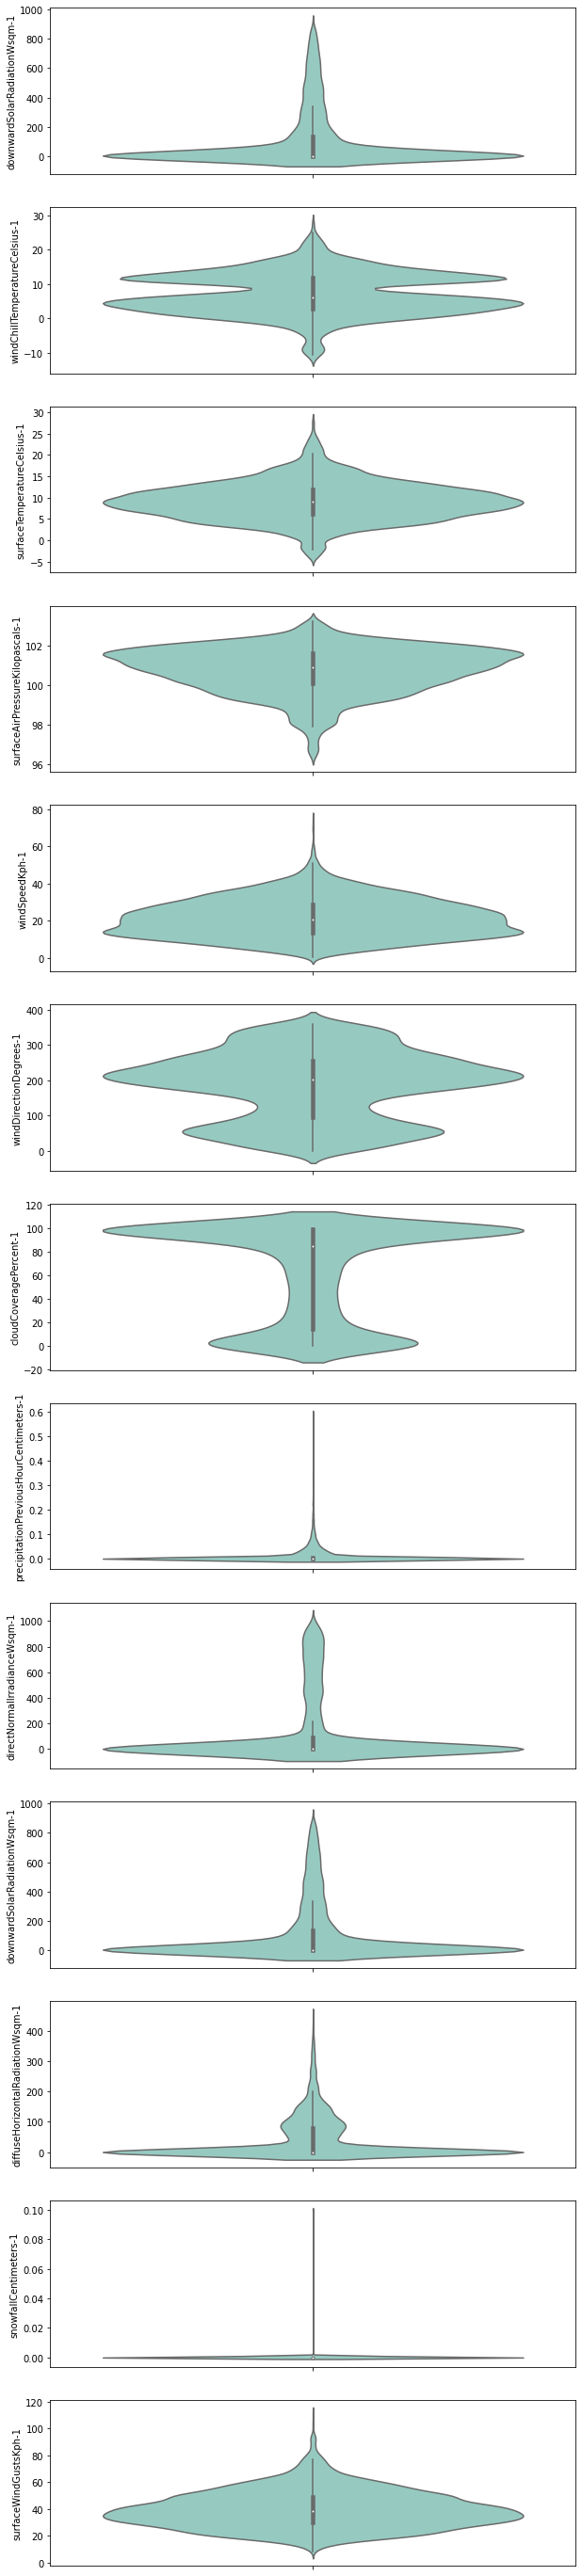

In [ ]:
liste_var_num = X_train[['downwardSolarRadiationWsqm-1', 'windChillTemperatureCelsius-1','surfaceTemperatureCelsius-1','surfaceAirPressureKilopascals-1',
                 'windSpeedKph-1','windDirectionDegrees-1','cloudCoveragePercent-1','precipitationPreviousHourCentimeters-1','directNormalIrradianceWsqm-1',
                 'downwardSolarRadiationWsqm-1','diffuseHorizontalRadiationWsqm-1','snowfallCentimeters-1','surfaceWindGustsKph-1']]
fig, axes = plt.subplots(13, 1, figsize = (10, 50), sharex = True)
for name, ax in zip(liste_var_num, axes):
    sns.violinplot(data = X_train, y = name, ax = ax, palette = "Set3") 

In [ ]:
# Suppression des variables non discriminantes
col_1 = [k for k in X_train._get_numeric_data().columns if 'precipitationPreviousHourCentimeters' in k]
col_2 = [k for k in X_train._get_numeric_data().columns if 'snowfallCentimeters' in k]

X_train = X_train.drop(columns = col_1 + col_2)
X_test = X_test.drop(columns = col_1 + col_2)

**Analyse des correlations**

>>> L'ensemble des variables sont faiblement ou non corrélées aux variables d'ouput. 

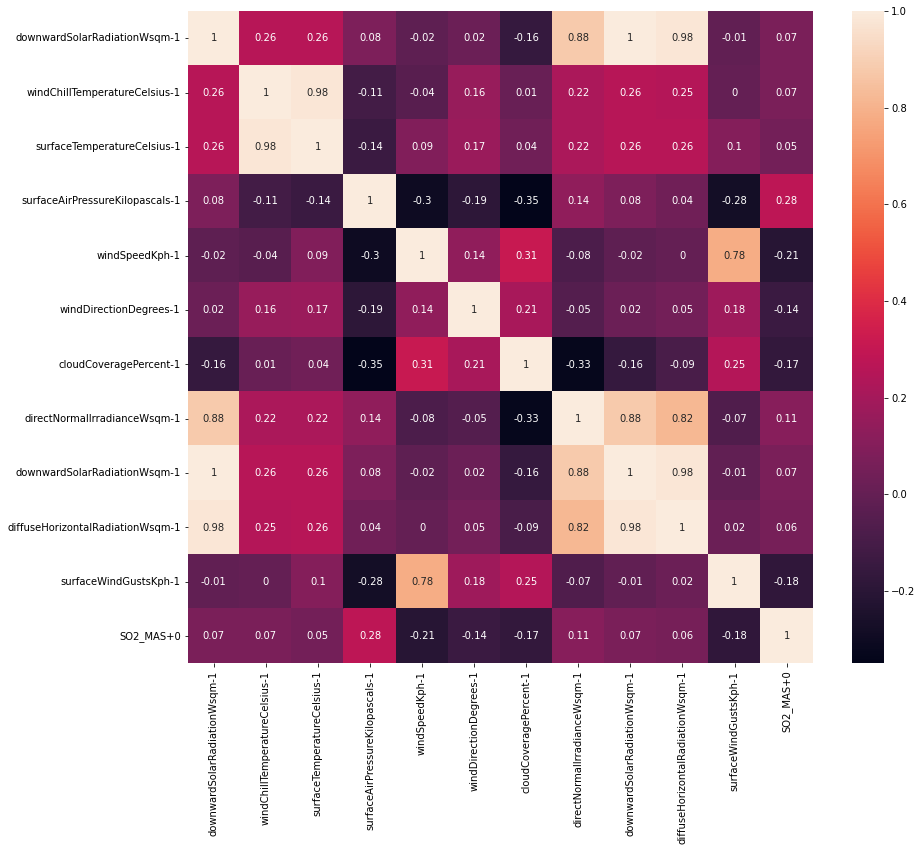

In [ ]:
var = ['downwardSolarRadiationWsqm-1', 'windChillTemperatureCelsius-1','surfaceTemperatureCelsius-1','surfaceAirPressureKilopascals-1',
                 'windSpeedKph-1','windDirectionDegrees-1','cloudCoveragePercent-1','directNormalIrradianceWsqm-1',
                 'downwardSolarRadiationWsqm-1','diffuseHorizontalRadiationWsqm-1','surfaceWindGustsKph-1']

corr_df_info = pd.concat([X_train[var], y_train['SO2_MAS+0']], axis=1)
corrMatrix2 = round(corr_df_info.corr(method = "spearman"),2)
plt.figure(figsize = (14,12))
sns.heatmap(corrMatrix2, annot = True)
plt.show()

<b><FONT size="5" color='olive'> 3) Modélisation </FONT>

<b><FONT size="4" color='teal'>3.1) Train/Validation Split </FONT>

>> Nous séparons aléatoirement les données d'entrainement et de validation car comme évoqué précédemment, le dataset de test est melangé aléatoirement. 
- L'échantillon de validation permet de réguler les hyper-paramètres des modèles. 
- Nous sélectionnons le modèles avec le meilleur compromis biais-variance: bonnes performances sur le train et sur le valid afin d'éviter tout risque d'overfitting. 

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, random_state = 0) # Split

In [ ]:
# Dimensions 
print("Finalement, la dimension du dataset des variables explicatives d'entraînement est de", X_train.shape)
print("Celle de l'échantillon de validation est de", X_valid.shape)
print("Finalement, la dimension du dataset des variables expliquées d'entraînement est de", y_train.shape)
print("Celle de l'échantillon de validation est de", y_valid.shape)

Finalement, la dimension du dataset des variables explicatives d'entraînement est de (5480, 960)
Celle de l'échantillon de validation est de (609, 960)
Finalement, la dimension du dataset des variables expliquées d'entraînement est de (5480, 12)
Celle de l'échantillon de validation est de (609, 12)


<b><FONT size="4" color='teal'>3.2) Modèles de Machine Learning </FONT>

<b><FONT size="4" color='navy'>3.2.1) Modèle de régression linéaire </FONT>

Modèle de régression linéaire (avec pénalité "ElasticNet") dans lequel nous faisons varier les hyperparamètres suivants: 
- 'l1_ratio': la pénalité
- 'alpha': le paramètre de poids de la régulation



In [ ]:
results_model = []

# Variations des hyperparamètres 
for alpha in 10. ** np.arange(-4, 1): # parametre de poids 
  for l1_ratio in  10. ** np.arange(-4, 1): # penalite
    for max_iter in [50, 100, 150]:
      model = ElasticNet(alpha = alpha, l1_ratio = l1_ratio, max_iter = max_iter).fit(X_train, y_train) # Entrainement du modèle 

      # Predictions
      y_pred_train = model.predict(X_train)
      y_pred_valid = model.predict(X_valid)
      y_pred_test = model.predict(X_test)
      
      # Evaluation
      MSE_train = mean_squared_error(y_train, y_pred_train)
      MSE_valid = mean_squared_error(y_valid, y_pred_valid)

      # DataFrame des résultats 
      results_model.append({'alpha': alpha,'l1_ratio': l1_ratio,'max_iter': max_iter, 'Train Score': MSE_train, 'Validation Score': MSE_valid, 'y_pred': y_pred_test})

results_model = pd.DataFrame(results_model)
best_results_RL = results_model[results_model['Validation Score'] == results_model['Validation Score'].min()] 
best_results_RL

,alpha,l1_ratio,max_iter,Train Score,Validation Score,y_pred
74,1.0,1.0,150,20.619785,14.513767,"[[0.2776598463366564, 2.1859125225924507, 3.23..."


In [ ]:
# Placement dans une df
df_y_pred = pd.DataFrame((best_results_RL.iloc[0, 5]), columns = y_train.columns) 
# Insert ID
df_y_pred['ID'] = df_y_pred.index + 1 
column_ID = df_y_pred.pop('ID')
df_y_pred.insert(0,'ID',column_ID)
df_y_pred = df_y_pred.reset_index(drop = True)
# Export 
df_y_pred.to_csv(data_dir + 'RL.csv',index = False)
df_y_pred.head()

,ID,SO2_MAS+0,SO2_MAS+1,SO2_MAS+2,SO2_MAS+3,SO2_MAS+4,SO2_MAS+5,SO2_MAS+6,SO2_MAS+7,SO2_MAS+8,SO2_MAS+9,SO2_MAS+10,SO2_MAS+11
0,1,0.277660,2.185913,3.230247,3.157244,1.953675,2.561244,3.225922,2.597000,2.842471,2.144222,2.215596,2.197367
1,2,-0.501643,-0.582377,-0.959846,-0.923888,-0.288991,0.835234,0.376606,0.058575,0.494832,0.146297,-1.080644,-1.104223
2,3,-4.291496,-3.148646,-3.855664,-2.337287,-1.132273,1.763878,5.757609,5.751731,7.727234,15.675467,17.696130,13.988287
3,4,-2.312472,-2.425905,0.917816,1.344683,2.391867,6.514487,6.423268,3.520041,0.043303,-1.020614,-3.375910,-2.106596
4,5,0.558068,1.026656,0.514652,-0.995948,-0.310239,0.493493,-0.108435,-1.101675,-0.293780,0.340972,1.213158,0.678664


**Résultat:**
- MSE sur le train: 20.62
- MSE sur le valid: 14.51
- MSE sur le test (plateforme): 45.78
>>> La MSE sur l'échantillon du train est supérieure à celle de l'échantillon de validation, signifiant que l'erreur sur le train est plus importante. Nous constatons donc un sous apprentissage du modèle. Cela a également des répercussions sur le test car l'erreur sur ce dernier est d'autant plus importante. 
>>> Notons, cependant qu'avec une régression linéaire, nous gagnons en performance en comparaison au benchmark de Veolia ayant une MSE de plus de 46. 

<b><FONT size="4" color='navy'>3.2.2) Catboost </FONT>

Modèle de boosting dans lequel nous faisons varier les hyperparamètres suivants: 
- 'depth': la profondeur des arbres 
- 'learning_rate': apprenants 


In [ ]:
results_model_CB = []

for depth in [4, 5, 6, 10]: # Profondeur des arbres
  for learning_rate in [0.1, 0.2, 0.3, 0.4]: # apprenants
    model = CatBoostRegressor(depth = depth, loss_function = 'MultiRMSE', eval_metric = 'MultiRMSE', 
                                learning_rate = learning_rate, iterations = 50).fit(X_train, y_train) # Training

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    y_pred_test = model.predict(X_test)

    # Evaluation
    MSE_train = mean_squared_error(y_train, y_pred_train)
    MSE_valid = mean_squared_error(y_valid, y_pred_valid)

    # DataFrame des résultats 
    results_model_CB.append({'depth': depth,'learning_rate': learning_rate, 'Train Score': MSE_train, 'Validation Score': MSE_valid, 'y_pred': y_pred_test})

results_model_CB = pd.DataFrame(results_model_CB)
best_results_CB = results_model_CB[results_model_CB['Validation Score'] == results_model_CB['Validation Score'].min()]
best_results_CB

0:	learn: 20.2077629	total: 669ms	remaining: 32.8s
1:	learn: 19.7904311	total: 1.1s	remaining: 26.5s
2:	learn: 19.4344803	total: 1.52s	remaining: 23.8s
3:	learn: 19.1358194	total: 1.98s	remaining: 22.8s
4:	learn: 18.7397799	total: 2.41s	remaining: 21.7s
5:	learn: 18.3723432	total: 2.84s	remaining: 20.8s
6:	learn: 18.0213298	total: 3.29s	remaining: 20.2s
7:	learn: 17.7508739	total: 3.73s	remaining: 19.6s
8:	learn: 17.4767794	total: 4.16s	remaining: 19s
9:	learn: 17.3187723	total: 4.61s	remaining: 18.4s
10:	learn: 17.0309620	total: 5.04s	remaining: 17.9s
11:	learn: 16.8063916	total: 5.49s	remaining: 17.4s
12:	learn: 16.6317162	total: 5.92s	remaining: 16.8s
13:	learn: 16.4274842	total: 6.36s	remaining: 16.4s
14:	learn: 16.2479764	total: 6.8s	remaining: 15.9s
15:	learn: 16.0848252	total: 7.25s	remaining: 15.4s
16:	learn: 15.9664981	total: 7.66s	remaining: 14.9s
17:	learn: 15.7610492	total: 8.11s	remaining: 14.4s
18:	learn: 15.6166054	total: 8.56s	remaining: 14s
19:	learn: 15.4795396	total:

,depth,learning_rate,Train Score,Validation Score,y_pred
15,10,0.4,2.032036,8.28161,"[[1.4644481118380133, 3.343604839206432, 2.877..."


>>> Avec une MSE de 2 sur le train et de 8 sur le valid, nous constatons que le modèle overfit. Nous sélectionnons donc un modèle avec une moins bonne MSE mais qui cependant n'overfit pas. 

In [ ]:
results_model_CB.sort_values(by = 'Validation Score', ascending = True).head(10) # Sort by Validation Score

,depth,learning_rate,Train Score,Validation Score,y_pred
15,10,0.4,2.032036,8.281610,"[[1.4644481118380133, 3.343604839206432, 2.877..."
14,10,0.3,2.687363,8.594714,"[[2.1084265721158766, 5.898381623907323, 3.070..."
13,10,0.2,3.701149,9.066732,"[[1.8732550578857459, 4.516076411855583, 1.613..."
12,10,0.1,6.353335,10.039214,"[[0.8881668907735083, 0.9715252171658353, 1.55..."
10,6,0.3,6.694094,10.198484,"[[0.5814860651047931, 0.7061383949072801, 0.89..."
11,6,0.4,5.729803,10.408754,"[[2.7517973266858027, 7.657697360963691, 1.771..."
5,5,0.2,10.640535,10.568763,"[[1.147695107690953, 1.5170661750964751, 1.842..."
9,6,0.2,8.327515,10.583328,"[[2.2207172536466953, 5.596511754483716, 2.238..."
7,5,0.4,7.366354,10.586225,"[[0.40244209979959966, 0.8487486860259246, 1.2..."
6,5,0.3,8.785766,10.878350,"[[0.8060849453238719, 1.0663832264889308, 1.48..."


In [ ]:
df_y_pred = pd.DataFrame(results_model_CB.sort_values(by = 'Validation Score', ascending = True).iloc[7, 4], columns = y_train.columns)
df_y_pred['ID'] = df_y_pred.index + 1
column_ID = df_y_pred.pop('ID')
df_y_pred.insert(0,'ID', column_ID)
df_y_pred = df_y_pred.reset_index(drop = True)
df_y_pred.to_csv(data_dir + 'CB.csv',index = False)
df_y_pred.head()

,ID,SO2_MAS+0,SO2_MAS+1,SO2_MAS+2,SO2_MAS+3,SO2_MAS+4,SO2_MAS+5,SO2_MAS+6,SO2_MAS+7,SO2_MAS+8,SO2_MAS+9,SO2_MAS+10,SO2_MAS+11
0,1,2.220717,5.596512,2.238665,1.539536,1.539075,1.402961,1.501420,1.479579,1.321695,0.906251,0.673048,0.666133
1,2,0.460888,0.378086,0.314083,0.256788,0.301886,0.331537,0.287057,0.302519,0.341127,0.403735,0.423675,0.365274
2,3,1.411369,1.704290,1.687294,1.715016,2.202803,2.656909,2.445157,2.526429,3.272427,3.584658,3.176185,4.005514
3,4,1.109095,1.316428,1.436807,1.631004,1.728521,1.534767,1.290605,1.063803,0.980237,0.929995,0.888202,0.653811
4,5,0.495589,0.520613,0.482931,0.414389,0.425008,0.461126,0.440928,0.453075,0.502980,0.599515,0.665012,0.705021


**Résultat:**
- MSE sur le train: 10.64
- MSE le valid: 10.57
- MSE sur le test (plateforme): 47.25
>>> Malgré une performance égale sur le train et sur le valid, nous constatons une faible performance sur le test. 

<b><FONT size="4" color='teal'>3.3) Modèles de deep learning </FONT>

**Nouvelles dimensions pour les modèles de deep learning séquentiels:**

In [ ]:
X_train = np.array(X_train) # conversion en numpy array
X_train_re =np.reshape(X_train,(X_train.shape[0], 48, int(X_train.shape[1]/48))) # Nouvelle dimension

X_valid = np.array(X_valid)
X_valid_re = np.reshape(X_valid,(X_valid.shape[0], 48, int(X_valid.shape[1]/48)))

X_test = np.array(X_test)
X_test_re = np.reshape(X_test,(X_test.shape[0], 48, int(X_test.shape[1]/48)))

In [ ]:
print("La structure (Nb observations, Nb de periodes, Nb de variables) donne cette nouvelle dimension", X_train_re.shape, "à X_train")

La structure (Nb observations, Nb de periodes, Nb de variables) donne cette nouvelle dimension (5480, 48, 20) à X_train


**Hyperparamètres à faire varier pour le modèle LSTM et le modèle GRU:**
- 'Dropout' prend en compte qu’une partie des neurones au sein du modèle.  
- 'Early Stopping' apporte une vérification quand à la diminution de la fonction de perte à la fin de chaque apprentissage (epochs également variants)
- units: nombre de neurones
- learning: la grandeur de pas


<b><FONT size="4" color='navy'>3.3.1) LSTM (Long Short Term Memory) </FONT>

In [ ]:
model_LSTM = []
for epochs in  [30, 50, 80]: # Nb apprentissages
  for units in  [20, 30]: # Nb neurones
    for learning in [0.001, 0.01, 0.2] : # grandeur du pas 
      for dropout_rate in [0, 0.1, 0.2]: # cut du nombre de neurones utilises
        # modele            
        model = Sequential() 
        model.add(LSTM(units, activation = 'tanh', input_shape = (48, 20))) # LSTM avec une fonction d'activation tahn
        model.add(Dropout(dropout_rate)) # Couche de dropout
        model.add(Dense(y_train.shape[1])) # Couche de sortie
        opt = tf.keras.optimizers.RMSprop(learning_rate = learning) # Optimisateur 
        model.compile(loss = "mean_squared_error", optimizer = opt, metrics = [tf.keras.metrics.MeanSquaredError()]) # Model 
        print('---------------------------------------------------------------------------------------------------')
        print('model '+model.name)
        print('---------------------------------------------------------------------------------------------------')


        hitory = model.fit(X_train_re, y_train, epochs = epochs, batch_size = 500, validation_data = (X_valid_re, y_valid)) # Entrainement
        
        # Predictions 
        y_pred_train = model.predict(X_train_re)
        y_pred_valid = model.predict(X_valid_re)
        y_pred_test = model.predict(X_test_re)

        if np.isnan(y_pred_train).sum() == 0 and np.isinf(y_pred_train).sum() == 0:
          # Evaluation
          MSE_train = mean_squared_error(y_train, y_pred_train)
          MSE_valid = mean_squared_error(y_valid, y_pred_valid)


          model_LSTM.append({'epochs':epochs,'units':units, 'learning_rate':learning, 'droupout_rate': dropout_rate,'Train Score': MSE_train, 'Validation Score': MSE_valid, 'y_pred': y_pred_test})

results_model_LSTM = pd.DataFrame(model_LSTM)
best_results_LSTM = results_model_LSTM[results_model_LSTM['Validation Score'] == results_model_LSTM['Validation Score'].min()]
best_results_LSTM

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Epoch 20/30
11/11 [==============================] - 1s 112ms/step - loss: 32.5807 - mean_squared_error: 32.5807 - val_loss: 16.7931 - val_mean_squared_error: 16.7931
Epoch 21/30
11/11 [==============================] - 1s 114ms/step - loss: 32.0625 - mean_squared_error: 32.0625 - val_loss: 17.0973 - val_mean_squared_error: 17.0973
Epoch 22/30
11/11 [==============================] - 1s 104ms/step - loss: 32.1677 - mean_squared_error: 32.1677 - val_loss: 16.8320 - val_mean_squared_error: 16.8320
Epoch 23/30
11/11 [==============================] - 1s 89ms/step - loss: 31.8344 - mean_squared_error: 31.8344 - val_loss: 18.0979 - val_mean_squared_error: 18.0979
Epoch 24/30
11/11 [==============================] - 1s 122ms/step - loss: 32.3156 - mean_squared_error: 32.3156 - val_loss: 16.3910 - val_mean_squared_error: 16.3910
Epoch 25/30
11/11 [==============================] - 1s 120ms/step - loss: 31.8116 - mea

,epochs,units,learning_rate,droupout_rate,Train Score,Validation Score,y_pred
48,80,30,0.01,0.0,21.92688,14.103115,"[[2.8302975, 3.2960784, 3.5567336, 3.3356419, ..."


In [ ]:
df_y_pred = pd.DataFrame((best_results_LSTM.iloc[0, 6]), columns = y_train.columns)
df_y_pred['ID'] = df_y_pred.index + 1
first_column = df_y_pred.pop('ID')
df_y_pred.insert(0,'ID', first_column)
df_y_pred=df_y_pred.reset_index(drop = True)
df_y_pred.to_csv(data_dir + 'LSTM.csv',index = False)
df_y_pred.head()

,ID,SO2_MAS+0,SO2_MAS+1,SO2_MAS+2,SO2_MAS+3,SO2_MAS+4,SO2_MAS+5,SO2_MAS+6,SO2_MAS+7,SO2_MAS+8,SO2_MAS+9,SO2_MAS+10,SO2_MAS+11
0,1,2.830297,3.296078,3.556734,3.335642,2.681097,2.280127,1.895195,1.892622,1.827135,1.628398,1.783501,1.883920
1,2,-0.008964,0.017487,0.140406,0.044093,-0.178485,-0.281774,-0.314573,-0.504020,-0.590727,-0.505292,0.162545,0.596823
2,3,0.583174,0.951618,1.386749,1.338454,1.212614,1.195472,0.946107,0.507570,0.143623,-0.045883,0.024080,0.211083
3,4,0.869911,1.261019,1.662988,1.800795,1.638589,1.624895,1.428469,1.117371,0.733949,0.380772,0.534845,0.650491
4,5,-0.854373,-0.778026,-0.550259,-0.863927,-0.920319,-0.975485,-1.100465,-1.413761,-1.379345,-1.155371,-0.729813,-0.192521


**Résultat:**
- MSE sur le train: 21.93
- MSE le valid: 14.10
- MSE sur le test (plateforme): 43.02
>>> Tout d'abrord, nous constatons que le modèle n'overfit pas car sa performance sur le valid est supérieure à celle du train. 
>> Ce modèle permet d'améliorer le benchmark d'environ 3. 

<b><FONT size="4" color='navy'>3.3.2) GRU (Gated Reccurent Unit) </FONT>

In [ ]:
model_GRU = []
for epochs in  [30, 50, 80]: # Nb apprentissages
  for units in  [20, 30]: # Nb units 
    for learning in [0.001, 0.01, 0.2] : # grandeur du pas 
      for dropout_rate in [0, 0.1, 0.2]: # cut du nombre de neurones 
        # modele
        EarlyStop = EarlyStopping(monitor = "val_loss", min_delta = 0, patience = 5) # EarlyStopping        
        model = Sequential() 
        model.add(GRU(units, activation = 'tanh', input_shape = (48, 20))) # GRU avec une fonction d'activation tanh
        model.add(Dropout(dropout_rate)) # Couche de Dropout
        model.add(Dense(y_train.shape[1])) # Couche de sortie
        opt = tf.keras.optimizers.Adam(learning_rate = learning) # Optumisateur 
        model.compile(loss = "mean_squared_error", optimizer = opt, metrics = [tf.keras.metrics.MeanSquaredError()]) 
        print('---------------------------------------------------------------------------------------------------')
        print('model '+model.name)
        print('---------------------------------------------------------------------------------------------------')

        hitory = model.fit(X_train_re, y_train, epochs = epochs, batch_size = 500, validation_data = (X_valid_re, y_valid), callbacks=[EarlyStop]) # Training
        
        # Prediction
        y_pred_train = model.predict(X_train_re)
        y_pred_valid = model.predict(X_valid_re)
        y_pred_test = model.predict(X_test_re)

        if np.isnan(y_pred_train).sum() == 0 and np.isinf(y_pred_train).sum() == 0:
          
          # Evaluation
          MSE_train = mean_squared_error(y_train, y_pred_train)
          MSE_valid = mean_squared_error(y_valid, y_pred_valid)


          model_GRU.append({'epochs':epochs,'units':units, 'learning_rate':learning, 'droupout_rate': dropout_rate,'Train Score': MSE_train, 'Validation Score': MSE_valid, 'y_pred': y_pred_test})

results_model_GRU = pd.DataFrame(model_GRU)
best_results_GRU = results_model_GRU[results_model_GRU['Validation Score'] == results_model_GRU['Validation Score'].min()]
best_results_GRU

---------------------------------------------------------------------------------------------------
model sequential_54
---------------------------------------------------------------------------------------------------
Epoch 1/30
11/11 [==============================] - 5s 198ms/step - loss: 37.5064 - mean_squared_error: 37.5064 - val_loss: 19.2944 - val_mean_squared_error: 19.2944
Epoch 2/30
11/11 [==============================] - 1s 90ms/step - loss: 36.9872 - mean_squared_error: 36.9872 - val_loss: 19.0135 - val_mean_squared_error: 19.0135
Epoch 3/30
11/11 [==============================] - 1s 116ms/step - loss: 36.6854 - mean_squared_error: 36.6854 - val_loss: 18.8344 - val_mean_squared_error: 18.8344
Epoch 4/30
11/11 [==============================] - 1s 106ms/step - loss: 36.4643 - mean_squared_error: 36.4643 - val_loss: 18.7035 - val_mean_squared_error: 18.7035
Epoch 5/30
11/11 [==============================] - 1s 82ms/step - loss: 36.3066 - mean_squared_error: 36.3066 - val_

,epochs,units,learning_rate,droupout_rate,Train Score,Validation Score,y_pred
31,50,30,0.01,0.1,24.817961,14.986483,"[[-0.10860753, 0.1331293, 0.45150322, 0.766951..."


In [ ]:
df_y_pred = pd.DataFrame((best_results_GRU.iloc[0, 6]), columns=y_train.columns)
df_y_pred['ID']=df_y_pred.index + 1
first_column=df_y_pred.pop('ID')
df_y_pred.insert(0,'ID',first_column)
df_y_pred=df_y_pred.reset_index(drop=True)
df_y_pred.to_csv(data_dir +'GRU.csv',index=False)
df_y_pred.head()

,ID,SO2_MAS+0,SO2_MAS+1,SO2_MAS+2,SO2_MAS+3,SO2_MAS+4,SO2_MAS+5,SO2_MAS+6,SO2_MAS+7,SO2_MAS+8,SO2_MAS+9,SO2_MAS+10,SO2_MAS+11
0,1,-0.108608,0.133129,0.451503,0.766952,1.075096,1.529156,1.776575,1.692203,1.717546,1.896001,2.166966,2.127439
1,2,0.300053,0.275227,0.320568,0.262272,0.217371,0.105617,0.068073,-0.008080,0.059330,0.119146,0.105156,0.186008
2,3,0.990332,0.848491,0.809937,0.618236,0.530024,0.501601,0.435367,0.510639,0.553905,0.709362,0.625089,0.677724
3,4,0.483433,0.548768,0.747913,0.785891,0.776682,0.730419,0.679300,0.672422,0.680770,0.760596,0.710307,0.786531
4,5,0.377627,0.389905,0.421146,0.344762,0.288863,0.185323,0.166817,0.033431,0.133249,0.170312,0.129626,0.180715


**Résultat:**
- MSE sur le train: 24.82
- MSE le valid: 14.99
- MSE sur le test (plateforme): 49.03
>>> Tout d'abrord, nous constatons que le modèle n'overfit pas car sa performance sur le valid est meilleure que celle du train. 
>> Sa performance est cependant moins bonne que le benchark. 

<b><FONT size="5" color='navy'>Conclusion </FONT>
>> Malgré une erreur importante sur le train et sur l'échantillon de validation, le meilleur modèle est le LSTM avec une MSE de 43.02 contre 46.34 pour le benchmark de Veolia. 